In [ ]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
import copy
%matplotlib inline

**Installing The Microsoft Florence 2 Model**

In [ ]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
#!pip install timm einops flash_attn

## Defining The Prediction Function

In [ ]:
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

# OCR Application

In [49]:
url = "https://cdn.handwrytten.com/www/2020/02/home-hero-photo2%402x.png?download=true"
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


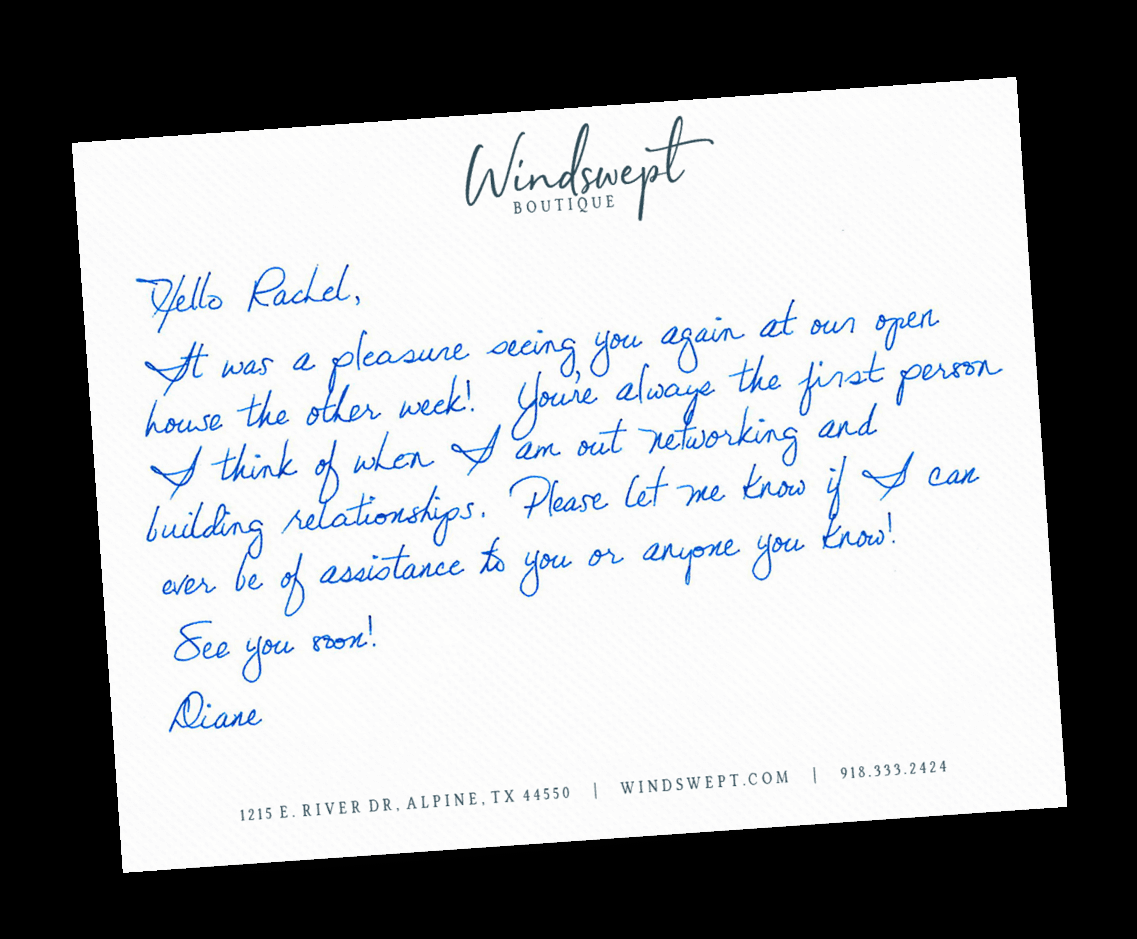

In [50]:
image

In [51]:
task_prompt = '<OCR>'
run_example(task_prompt)

{'<OCR>': 'WindsweptBOUTIQUEYello Rachel,It was a pleasure seeing you again at our openhouse the other week! youre always the first personI think of when I am out networking andbuilding relationships. Please let me know if I canever be of assistance to you or anyone you know!See you soon!Diane1215 E. RIVER DR. ALPINE, TX 44550 | WINDSWEPT.COM | 918.333.2424'}

In [52]:
task_prompt = '<OCR_WITH_REGION>'
results = run_example(task_prompt)
print(results)
# ocr results format
# {'OCR_WITH_REGION': {'quad_boxes': [[x1, y1, x2, y2, x3, y3, x4, y4], ...], 'labels': ['text1', ...]}}

{'<OCR_WITH_REGION>': {'quad_boxes': [[462.19049072265625, 140.38050842285156, 708.9194946289062, 117.84449768066406, 713.4674682617188, 186.39149475097656, 465.6014709472656, 207.98849487304688], [138.14549255371094, 273.718505859375, 360.99749755859375, 260.572509765625, 363.271484375, 308.4615173339844, 140.41949462890625, 322.5465087890625], [146.1044921875, 345.0824890136719, 939.73046875, 298.13250732421875, 942.0044555664062, 337.57049560546875, 148.3784942626953, 387.3374938964844], [142.69349670410156, 399.54449462890625, 1003.4024658203125, 346.96051025390625, 1005.6764526367188, 386.39849853515625, 143.8304901123047, 440.8605041503906], [149.5155029296875, 446.4945068359375, 880.6064453125, 403.3005065917969, 882.8804931640625, 444.61651611328125, 151.78948974609375, 492.5054931640625], [144.96749877929688, 503.77349853515625, 980.6624755859375, 450.2505187988281, 982.9364624023438, 493.44451904296875, 146.1044921875, 546.967529296875], [159.7484893798828, 564.8085327148438,

In [53]:
from PIL import Image, ImageDraw, ImageFont
import random
import numpy as np
colormap = ['blue','orange','purple','brown','red',
            'indigo','violet','magenta','coral','gold','tan','skyblue']

def draw_ocr_bboxes(image, prediction):
    scale = 1
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",

                    fill=color)
    display(image)

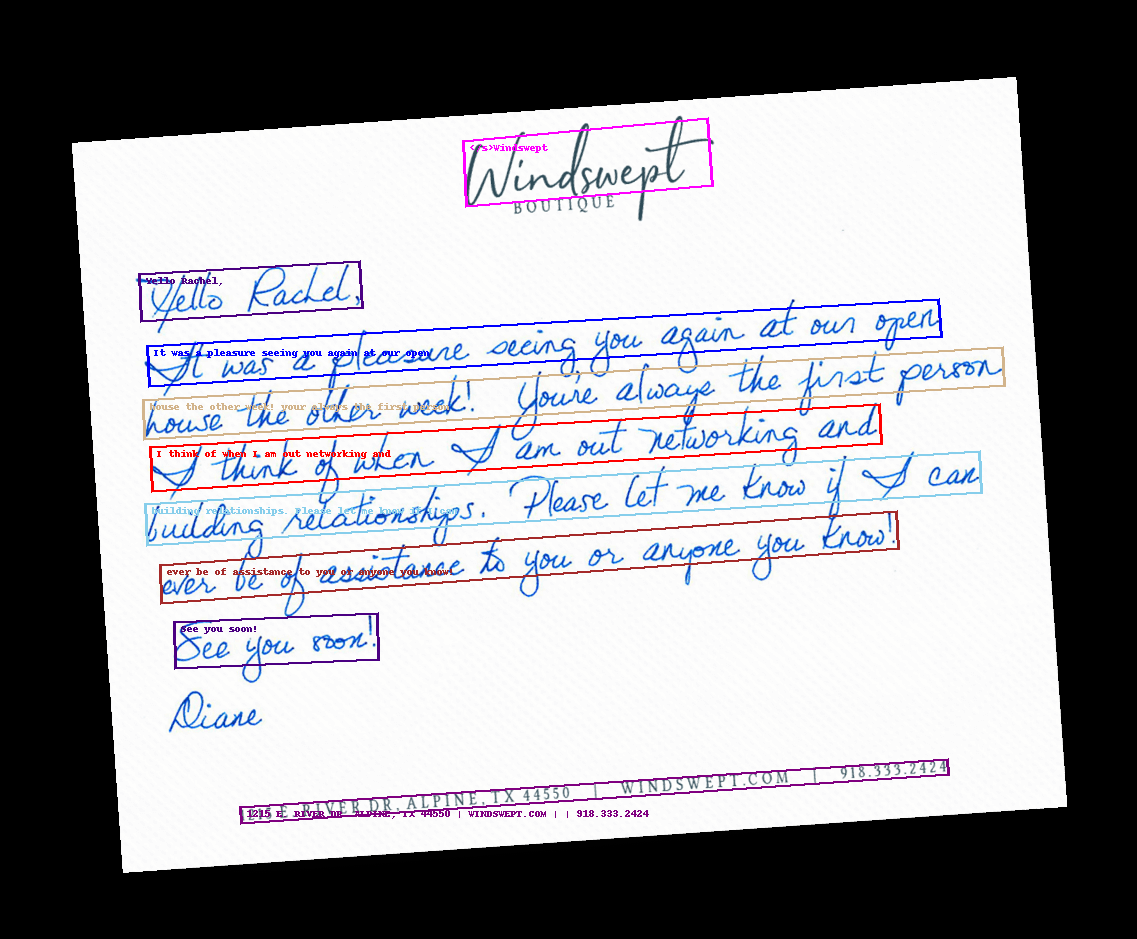

In [54]:
output_image = copy.deepcopy(image)
draw_ocr_bboxes(output_image, results['<OCR_WITH_REGION>'])